# Import Libraries

In [1]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

C:\Users\lenovo\anaconda3\envs\saad\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Load Datasets for Movies as items and their ratings Ratings 

In [2]:
movies_filename='movie.csv'
ratings_filename='rating.csv'

In [5]:
movies = pd.read_csv(movies_filename,usecols=['movieId', 'title'],
                     dtype={'movieId': 'int32', 'title': 'str'})

In [4]:
ratings = pd.read_csv(ratings_filename,usecols=['userId', 'movieId', 'rating'],
                      dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

# Data Analysis and Visualization

In [6]:
movies.shape

(9742, 2)

In [7]:
ratings.shape

(100836, 3)

In [8]:
ratings.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

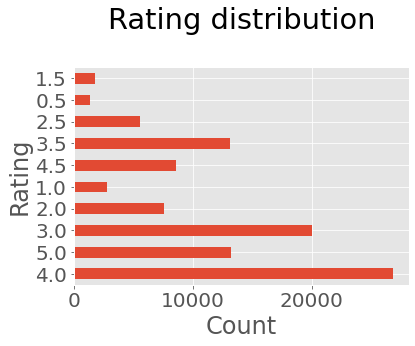

In [10]:
plt.rc("font",size=20)
ratings.rating.value_counts(sort=False).plot(kind='barh')
plt.title('Rating distribution\n')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

In [11]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(num_users,num_items))

There are 610 unique users and 9724 unique movies in this dataset


In [13]:
ratings_cnt_tmp=pd.DataFrame(ratings.groupby('rating').size(),columns=['count'])
ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [14]:
total_cnt=num_users * num_items


In [15]:
total_cnt

5931640

In [17]:
rating_zero_cnt = total_cnt - ratings.shape[0]

df_ratings_cnt = ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [18]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


In [20]:
df_movies_cnt=pd.DataFrame(ratings.groupby('movieId').size(),columns=['count'])
df_movies_cnt.head()
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [21]:
popularity_thres = 50
popular_movies=list(set(df_movies_cnt.query('count>=@popularity_thres').index))
df_ratings_drop_movies=ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data', ratings.shape)
print('shape of ratings data after dropping unpopular movies', df_ratings_drop_movies.shape)

shape of original ratings data (100836, 3)
shape of ratings data after dropping unpopular movies (41360, 3)


In [22]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


In [23]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

In [24]:
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)


In [25]:
df_ratings_drop_movies

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100657,610,106782,4.5
100672,610,109374,4.5
100673,610,109487,3.5
100701,610,112852,4.5


In [26]:
df_ratings_drop_users

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100657,610,106782,4.5
100672,610,109374,4.5
100673,610,109487,3.5
100701,610,112852,4.5


# Create Item Based Collaborative Filtering 

In [28]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)

movie_user_mat_1=movie_user_mat

In [29]:
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}

movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [30]:
movie_user_mat_sparse

<450x268 sparse matrix of type '<class 'numpy.float32'>'
	with 32999 stored elements in Compressed Sparse Row format>

In [31]:
movie_user_mat

userId,1,4,6,7,15,16,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,0.0,4.5,3.5,4.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
109487,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
112852,0.0,0.0,0.0,0.0,1.5,0.0,0.0,4.5,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5


# Apply KNN 

In [33]:
model_knn=NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

# Make Recommendations

In [34]:
query_index=np.random.choice(movie_user_mat.shape[0])
print(query_index)

176


In [35]:
distances, indices = model_knn.kneighbors(movie_user_mat.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [36]:
movie_user_mat.index[query_index]

1302

# Test Recommender

In [37]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_user_mat.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_user_mat.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 1302:

1: 2797, with distance of 0.43241167068481445:
2: 2918, with distance of 0.47208571434020996:
3: 1097, with distance of 0.48057568073272705:
4: 2302, with distance of 0.49427247047424316:
5: 1393, with distance of 0.5030287504196167:
